# PCA Experimentation

This notebook will conduct PCA on some datasets, using methods learnt through online courses, including edx UC San Diego MicroMasters and Coursera Machine Learning.

The datasets to be used are:
+ LFW accessed through the scikit learn library (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html)
+ MNIST (http://yann.lecun.com/exdb/mnist/)
+ MovieLens 1m dataset (https://grouplens.org/datasets/movielens/1m/)

PCA follows the following steps:
1. Data standardisation
2. Computing the covariance
3. Calculating the eigenvectors and eigenvalues
4. Computing the principal components
5. Reducing dataset dimensions

In [1]:
import math
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

%matplotlib inline

# 1. PCA on Faces

This will use the Labeled Faces in the Wild face recognition dataset from scikit learn - a collection of JPEG pictures of famous people collected over the internet.

The method used was developed as part of the Coursera Machine Learning course.

## Load the dataset

In [2]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Junichiro Koizumi' 'Tony Blair']
(1277, 62, 47)


In [3]:
#introspect images arrays to find shapes (for plotting)
n_samples, h, w = faces.images.shape

#use the 2 data directly (as relative pixel positions info is ignored by this model)
X = faces.data
n_features = X.shape[1]

#label to predict is person id
y = faces.target
target_names = faces.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("\tnumber of samples: %d" % n_samples)
print("\tnumber of features: %d" % n_features)
print("\tnumber of classes: %d" % n_classes)

Total dataset size:
	number of samples: 1277
	number of features: 2914
	number of classes: 7


## Plot a sample of the data

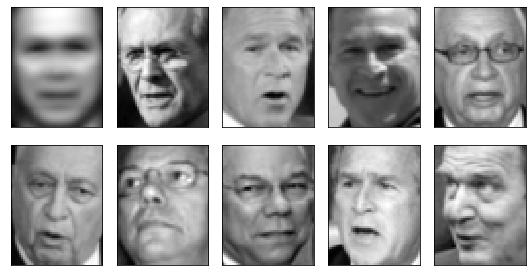

In [4]:
def plot_faces(images, n_row=2, n_col=5):
    plt.figure(figsize=(1.5 * n_col, 2.2 * n_row))
    plt.subplots_adjust(0.6, 0.5, 1.5, 1.5)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())
    plt.tight_layout()
    plt.show()
    

Xmean = np.mean(X,axis=0).reshape(1,n_features) # average face

#plot average face and some samples from the dataset
plot_faces(np.concatenate((Xmean,X[:9]),axis=0))

## Reduce dimensionality by running PCA

In [5]:
import scipy.linalg as linalg

#function to return normalised version of X where mean is 0 and std is 1
def featureNormalize(X):
    mu = np.mean(X, axis=0)
    X_norm = X - mu
    #set Delta Degrees of Freedom to 1, to compute
    # std based on a sample and not the population
    sigma = np.std(X_norm, axis=0, ddof=1)
    X_norm = X_norm / sigma
    
    return X_norm, mu, sigma

#function to compute eigenvectors and eigenvalues, returns the 
#eigenvectors U, eigenvalues (on diagonal), S
def pca(X):
    m, n = X.shape
    
    #init U and S.
    U = np.zeros(n)
    S = np.zeros(n)
    
    #when computing covariance matrix, divide by m (number of examples)
    sigma = (1. / m) * np.dot(X.T, X)
    
    #compute eigenvectors and eigenvalues of covariance matrix
    U, S, V = linalg.svd(sigma)
    S = linalg.diagsvd(S, len(S), len(S))

    return U, S

Running PCA on face dataset...


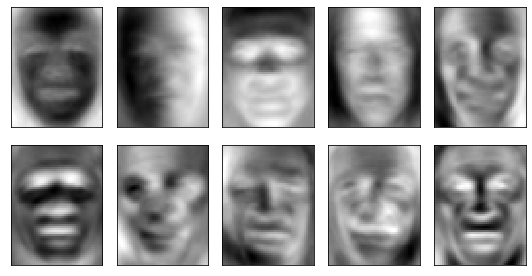

In [6]:
print('Running PCA on face dataset...')

#before running PCA, normalise X by subtracting mean value from each feature
faces_norm, _, _ = featureNormalize(X)

#run PCA
U, S = pca(faces_norm)

#visualise top eigenvectors
plot_faces(U.T)

## Project and recover the data

The principal component can now be used to reduce the feature dimension of the dataset by projecting each example onto a lower dimensional space.

After projecting the data onto a lower dimensional space, data can be approximately recovered by projecting them back onto the original high dimensional space.

The difference between the original high dimensional data and the recovered data will be visualised below.

In [7]:
#function that computes projection of normalised inputs X into reduced dimensional space 
#spanned by first K columns of U returns projected examples in Z.
def projectData(X, U, K):
    #init Z.
    Z = np.zeros((X.shape[0], K)) # m * K
    
    #compute projection of data using only top K eigenvectors in U (first K columns)
    U_reduce = U[:,:K]
    Z = np.dot(X, U_reduce)

    return Z

#function to recover approximation of original data that was reduced to k dimensions
def recoverData(Z, U, K):
    #init X_rec.
    X_rec = np.zeros((Z.shape[0], U.shape[0]))
    
    #compute approximation of data by projecting back onto original space using top K eigenvectors in U
    U_reduce = U[:,: K]
    X_rec = np.dot(Z, U_reduce.T)

    return X_rec

Dimension reduction for face dataset...

The projected data Z has a size of: 
1277 100

Visualizing the projected (reduced dimension) faces.

Original faces:


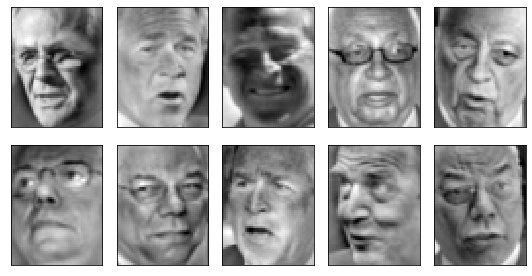


Recovered faces:


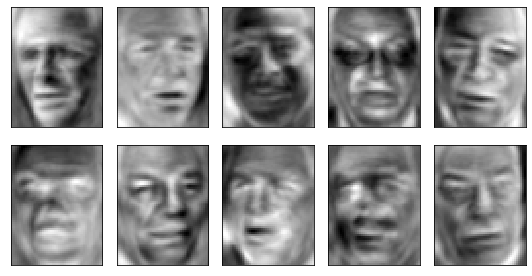

In [8]:
print('Dimension reduction for face dataset...')

K = 100
Z = projectData(faces_norm, U, K)

print('\nThe projected data Z has a size of: ')
print('{} {}'.format(Z.shape[0], Z.shape[1]))

print('\nVisualizing the projected (reduced dimension) faces.');

X_rec = recoverData(Z, U, K)

#display normalised data.
print('\nOriginal faces:')
plot_faces(faces_norm)

#display reconstructed data from only k eigenfaces.
print('\nRecovered faces:')
plot_faces(X_rec)

# 2. PCA on MNIST

With the large number of 0 values in the MNIST data arrays, the previous method struggles. Therefore, a different method will be used, which was developed as part of the edx UC San Diego MicroMasters.

In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import gzip, sys, os

if sys.version_info[0] == 2:
    from urllib import urlretrieve
else:
    from urllib.request import urlretrieve

In [10]:
def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
    print("Downloading %s" % filename)
    urlretrieve(source + filename, filename)

def load_mnist_images(filename):
    if not os.path.exists(filename):
        download(filename)
    #read inputs in Yann LeCun's binary format
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1,784)
    return data / np.float32(256)

In [11]:
#load training set
train_data = load_mnist_images('train-images-idx3-ubyte.gz')

## Covariance matrix information

PCA chooses projection directions based on the covariance martix of the data. The matrix allows contrasts to be made of the effects of picking coordinate directions vs eignevector directions. 

These comparisons will be visualised in the plot below, to show the benefit of eignevector projections over coordinate projections in terms of variance lost when projection dimension is reduced.

In [12]:
#compute covariance matrix
Sigma = np.cov(train_data, rowvar=0, bias=1)

#compute coordinate-wise variances in increasing order
coordinate_variances = np.sort(Sigma.diagonal())

#compute variances in eigenvector directions in increasing order
eigenvector_variances = np.sort(np.linalg.eigvalsh(Sigma))

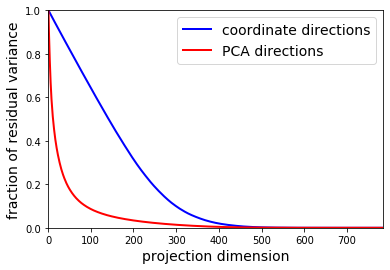

In [13]:
#compute fraction of overall variance lost when projecting to k coordinate directions
total_coordinate_variance = np.cumsum(coordinate_variances)
total_coordinate_variance = total_coordinate_variance/total_coordinate_variance[783]

#compute fraction of overall variance lost when projecting to k eigenvector directions
total_eigenvector_variance = np.cumsum(eigenvector_variances)
total_eigenvector_variance = total_eigenvector_variance/total_eigenvector_variance[783]

#plot results
plt.plot(np.arange(1,784), total_coordinate_variance[784:0:-1], 'b-', lw=2)
plt.plot(np.arange(1,784), total_eigenvector_variance[784:0:-1], 'r-', lw=2)
plt.xlabel('projection dimension', fontsize=14)
plt.ylabel('fraction of residual variance', fontsize=14)
plt.xlim(0,784)
plt.ylim(0.0,1.0)
plt.legend(['coordinate directions', 'PCA directions'], fontsize=14)
plt.show()

This plot shows that at around 400 dimensions, with coordinate directions fraction of residual variance rapidly falls with falling dimensions. However, with PCA directions, less information is lost with falling dimensionality, with the loss being a a slower rate, and only at around 50 does the variance lost increase rapidly. 

## Projection and reconstruction

In [14]:
eigenvalues, eigenvectors = np.linalg.eigh(Sigma)

In [15]:
#function that returns project-and-reconstruct operations as a single matrix
def projection_and_reconstruction(k):
    U = eigenvectors[:,(784-k):784]
    P = np.dot(U,U.T)
    return P

In [16]:
def show_digit(x):
    #all entries of x must be in range [0,255]
    for i in range(784):
        x[i] = max(0.0, x[i])
        x[i] = min(255.0, x[i])
    
    #display
    plt.axis('off')
    plt.imshow(x.reshape((28,28)), cmap=plt.cm.gray)
    plt.show()
    return

In [17]:
def show_effect_of_PCA(x, k_list):
    print("Original:")
    show_digit(x)
    for k in k_list:
        if (k > 0) and (k < 784):
            print("Projection to dimension ", k)
            P = projection_and_reconstruction(k)
            show_digit(P.dot(x))

## Example

Original:


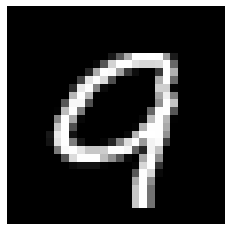

Projection to dimension  100


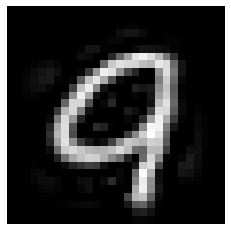

Projection to dimension  50


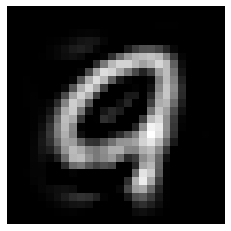

Projection to dimension  25


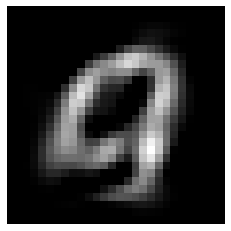

Projection to dimension  10


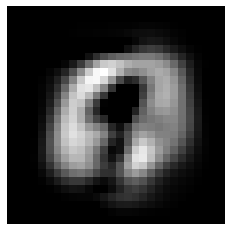

In [18]:
index = 3000
show_effect_of_PCA(train_data[index,], [100, 50, 25, 10])

The digit appears to be recognisable until about dimension 25 and below.

# 3. PCA on MovieLens 1m dataset

This dataset is found here: https://grouplens.org/datasets/movielens/

This dataset contains 1,000,209 anonymous ratings of approximately 3,900 movies (features) made by 6,040 MovieLens users (instances) who joined MovieLens in 2000.

The goal of PCA here is to reduce the features dimensionality.

In [19]:
#load dependencies
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from matplotlib import*
import matplotlib.pyplot as plt
from matplotlib.cm import register_cmap
from scipy import stats
from sklearn.decomposition import PCA as PCA
import seaborn
import warnings
warnings.filterwarnings('ignore')

## Load and preprocess data

In [20]:
#load movie names and movie ratings
movies = pd.read_csv('ml-1m/movies.csv', sep='::', names=['movieId','title','genres'])
ratings = pd.read_csv('ml-1m/ratings.csv', sep="::", names=['userId','movieId','rating','timestamp'])

In [21]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [22]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [23]:
ratings.drop(['timestamp'], axis=1, inplace=True)

def replace_name(x):
    return movies[movies['movieId']==x].title.values[0]

ratings.movieId = ratings.movieId.map(replace_name)

M = ratings.pivot_table(index=['userId'], columns=['movieId'], values='rating')
m = M.shape

df1 = M.replace(np.nan, 0, regex=True)


In [24]:
#standardisation
X_std = StandardScaler().fit_transform(df1)

In [25]:
X_std.shape

(6040, 3706)

In [26]:
#calculate eigenvectors and eigenvalues on cov matrix
Sigma_mov = np.cov(X_std.T)
eigenvalues_mov, eigenvectors_mov = np.linalg.eig(Sigma_mov)

In [27]:
print('Eigenvectors \n%s' %eigenvectors_mov)
print('\nEigenvalues \n%s' %eigenvalues_mov)

Eigenvectors 
[[ 0.00992449+0.j -0.00253718+0.j -0.00105089+0.j ...  0.01810272+0.j
  -0.01239472+0.j  0.0035155 +0.j]
 [ 0.01517728+0.j  0.0206369 +0.j  0.00816541+0.j ...  0.01101112+0.j
   0.00036972+0.j -0.02605393+0.j]
 [ 0.01026777+0.j -0.00066536+0.j  0.02237704+0.j ...  0.00372644+0.j
  -0.01076024+0.j  0.00928649+0.j]
 ...
 [ 0.00720997+0.j  0.01009321+0.j -0.00328861+0.j ...  0.00321645+0.j
   0.01477754+0.j  0.01507362+0.j]
 [ 0.00806396+0.j -0.00536386+0.j  0.00565419+0.j ...  0.00762576+0.j
   0.00599979+0.j -0.01894194+0.j]
 [ 0.01719711+0.j  0.00335323+0.j  0.00586364+0.j ...  0.00497987+0.j
   0.0264488 +0.j  0.00199283+0.j]]

Eigenvalues 
[2.54039541e+02+0.j 8.52315066e+01+0.j 5.54441178e+01+0.j ...
 4.66688420e-02+0.j 5.07366043e-02+0.j 4.66657978e-02+0.j]


In [28]:
#compute feature vector
eig_pairs = [(np.abs(eigenvalues_mov[i]), eigenvectors_mov[:,i]) for i in range(len(eigenvalues_mov))]

#sort (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda k: k[0], reverse=True)

In [29]:
#confirm list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
254.03954059054308
85.23150663110609
55.44411783195683
50.37170322605311
43.603585817165175
37.40611378576861
35.25758868412515
29.193922085380844
26.039310271221982
23.80530315618863
22.59497269722021
17.73990724054622
16.483326496551534
15.350299127250588
14.777904223729855
14.218322454007426
13.905962757235242
13.449497526184473
12.7772340725194
12.004610961418923
11.577728866508853
11.228273788221891
10.823813095117645
10.612850553830652
10.236957790633163
9.646844663718893
9.543427755316142
9.399364145591099
9.065563539362184
8.846722890560113
8.789980077226872
8.379476561652723
8.161291443287084
8.046024476121406
7.960583578633471
7.767862998511615
7.745860629353575
7.673889159920361
7.500445654402132
7.426083016999905
7.262078627262695
7.18491243210316
7.086190913815352
6.899344922009216
6.8520943345862575
6.823068689199158
6.776858824133976
6.6919188865327675
6.5412791795663185
6.50046812717481
6.460814764494859
6.3254822724859165
6.236341322896

1.0778200510639053
1.0759845880251135
1.0750503534070002
1.0733076661357388
1.0722368832588134
1.0701287032952502
1.068922939160756
1.0684688856787155
1.067137330398216
1.0661966054922634
1.0635676276038828
1.0633768530553598
1.0616849050609207
1.0603973045263875
1.0585669928417138
1.0579341563350957
1.0570068653808071
1.0566666214750835
1.0557345937873046
1.0534293288163077
1.052621963611876
1.052374264528641
1.0503190312418667
1.0496924006459167
1.0485641966978942
1.0465136914227222
1.0463619650967988
1.0451597061384672
1.0416923788997587
1.041237212500129
1.0391232318677062
1.0383911622822881
1.0378015270341943
1.0357960631841672
1.0350347092088426
1.033581275069233
1.0318766361284526
1.0307274706802438
1.0294838454148454
1.028547140500789
1.0278080421196272
1.0267463015764196
1.0258340931898395
1.0248388764975076
1.0233927026441685
1.0227738783473406
1.0220059938144237
1.0204147185726378
1.0199206732306774
1.0184626124258047
1.0177775176242485
1.0167341811971269
1.015894348772794
1

0.5016615320259482
0.5013009531392066
0.5002437420323628
0.4997429370997078
0.49885922246147235
0.49875575452001863
0.4983930370801541
0.4978748902196184
0.49691327061239887
0.49661140494809053
0.49599503320202926
0.49533379218309476
0.494812727193999
0.49405993367166934
0.49288743933855966
0.4927783993240105
0.49223953470157866
0.4921696073635248
0.4913587759567042
0.4910825775918311
0.490485645259282
0.4900342574416627
0.4887922999516086
0.48862897119239573
0.48790275783889936
0.4875421260879376
0.4866471057646164
0.4859215914784566
0.485729128610491
0.4852490707240722
0.4851499218347458
0.4845713592423057
0.4837817687621133
0.4827582929612825
0.4822153930014419
0.4817503358630773
0.48152087513207115
0.48134525855025345
0.4806768386488517
0.48041776999139035
0.4793853339588312
0.47876370509589705
0.47865659594220517
0.47753127581159377
0.47724509052948305
0.47696603624607586
0.4768102486907338
0.476197833660802
0.47572788270682087
0.47521324565544787
0.4747712973742636
0.474385866255

0.1535548429482801
0.1532460240351377
0.15302604316688906
0.15286476456166354
0.15265681846665433
0.15250371902218907
0.15237765067471365
0.15217399246820187
0.15174799999864885
0.15155989039365259
0.15131230004550905
0.15103535558329506
0.15066470237628762
0.150612774984637
0.1504782140447356
0.15030734317823813
0.15005063766148444
0.14996644975091528
0.14986186553743414
0.1497259930530541
0.1496145743185268
0.14900458696590743
0.14895230229629078
0.14871493656181514
0.14854678927611206
0.14836389439723666
0.14820028081419467
0.1480167483428089
0.14776984161604806
0.14751428787783707
0.14734523381049497
0.1470538966170739
0.14694803118765482
0.1466120146235293
0.14640761974164432
0.14609792913877098
0.1457851131619201
0.14576421207242132
0.14567800266859937
0.14512482228617213
0.1449531512285742
0.1448097556694212
0.14465381703809635
0.14459104931331845
0.14430462265199923
0.14406001109322442
0.14394524639997827
0.143774211916529
0.1435858418110215
0.14351786904886737
0.14320363151850

0.07941403560674222
0.0792698278512046
0.07901639351949258
0.07886900509529327
0.07867311844736792
0.07865862997635553
0.07857051687314821
0.07833118623097916
0.07826255625708334
0.07812548254790469
0.07796338621745652
0.07791542073979553
0.07778682604459869
0.07757682051689266
0.07748026665405935
0.0772894638177741
0.07718062938024918
0.07700684933139638
0.07682958498423925
0.07668819905858483
0.07661465767942593
0.07645164643323261
0.07630211121713042
0.07613813796257954
0.07603431656659287
0.07594797464440499
0.07584200918212033
0.07559774809252845
0.07557305950784517
0.0754059250331578
0.07532546917085092
0.07513525107187916
0.07488298518231844
0.07473352467626725
0.07465561214356
0.07457732399814458
0.07441898716221157
0.07437966385806577
0.07422114692936807
0.07413726883970106
0.07403954087646657
0.07394252861771909
0.07375021522211374
0.07371951966332806
0.07359812180185261
0.07339429076523749
0.07329555770835972
0.07317798388055456
0.07308750814290003
0.07280431235312021
0.0725

In [30]:
#choosing top k eigenvectors - ones explaining most of the variation
tot = sum(eigenvalues_mov)
var_exp = [(i / tot)*100 for i in sorted(eigenvalues_mov, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

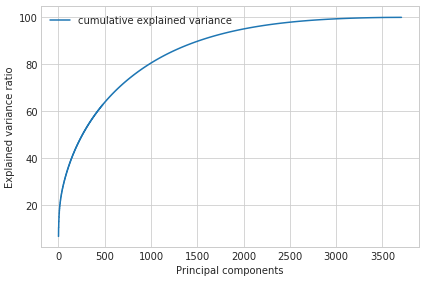

In [31]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))

    plt.step(range(X_std.shape[1]), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

In [34]:
#reducing dataset dimensions by projecting onto new feature space 
X_std_pca = X_std.dot(eigenvectors_mov[:, 0:1500])

In [35]:
X_std_pca.shape

(6040, 1500)